# Package

In [1]:
#Torch related package
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchviz
from torch.utils import data

In [2]:
#cuda related package
import torch.cuda
import torch.backends.cudnn as cudnn
print(torch.backends.cudnn.version())

6021


In [3]:
# Other package
import time
import random
from ggplot import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import csv
import os
from PIL import Image
import seaborn as sns; sns.set()


/home/tanguy/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/tanguy/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/tanguy/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
%reload_ext autoreload
%autoreload 2

In [156]:
%run GridNet_structure.ipynb #Good trick to launch another notebook
%run Plot.ipynb 
%run Save_import.ipynb
%run Loss_Error.ipynb

# Commentaire pour la suite (TODO)

Le batch normalisation, il y en existe plusieurs, regarder exactement lequel on veut.

On peut enlever le biais dans les convolutions avant la normalisation

Le diminution de la taille des images, pas clair cette division par deux....

Change la fonction de cout

Il faut enlever les biais quand il y a une batch normalisation apres

Vérifier ce qu'est la mesure de test IoU

# Code

In [5]:
class Parameters():
    def __init__(self,
                 nColumns = 2,
                 nFeatMaps = [3,6],
                 nFeatureMaps_init = 3,
                 number_classes = 20,

                 width_image_initial = 2048, height_image_initial = 1024,
                 width_image_crop = 19, height_image_crop = 19,

                 dropFactor = 0.1,
                 learning_rate=0.01,
                 weight_decay = 5*10**(-6),
                 beta1 = 0.9,
                 beta2 = 0.999,
                 epsilon = 1*10**(-8),
                 batch_size = 2,
                 epoch_total = 10,
                 # The actual epoch is not null if we train the network which is already train
                 actual_epoch = 0,

                 path_save_net = "Model/",
                 #Name of the network, used for store
                 name_network = "test",
                 train_number = 0,
                 path_CSV = "CSV/",
                 path_data = "/media/tanguy/Seagate Expansion Drive/Cityscapes_Copy"):
        
        super(Parameters, self).__init__()
        # Image
        self.number_classes = number_classes
        self.width_image_initial = width_image_initial
        self.height_image_initial = height_image_initial
        self.width_image_crop = width_image_crop
        self.height_image_crop = height_image_crop
        # Number of feature map at the begining, if RGB image it would be 3
        self.nFeatureMaps_init = nFeatureMaps_init
        self.path_data = path_data
        
        # GridNet
        self.nColumns = nColumns
        self.nFeatMaps = nFeatMaps
        self.name_network = name_network
        self.train_number = train_number
        
        #Save
        self.path_CSV = path_CSV
        self.path_save_net = path_save_net
        
        
        # Learning
        self.dropFactor = dropFactor
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epoch_total = epoch_total
        self.actual_epoch = actual_epoch

In [118]:
"""train return nothing but modify the weight of the network and call save_error to store the error.
    (0) = parameters : list of parameters of the network
    (1) = x_train : inputs of the training set
    (2) = y_train : outputs of the training set
    (3) = x_validation : inputs of the validation set
    (4) = y_validation : outputs of the validation set
"""
def train(parameters,network,train_loader,val_loader):
     
    # create your optimizer
    optimizer = optim.Adam(params = network.parameters(), lr = parameters.learning_rate,
                           betas = (parameters.beta1, parameters.beta2),
                           eps = parameters.epsilon, weight_decay = parameters.weight_decay)
    for epoch in range(parameters.epoch_total):

        for i,(x_batch, y_batch) in enumerate(train_loader):

            # zero the gradient buffers
            optimizer.zero_grad()
            
            #Transform into Variable
            x_batch, y_batch = Variable(x_batch), Variable(y_batch)
            
            # Compute the forward function
            y_batch_estimated = network(x_batch)
            
            #Get the error
            loss = criterion(y_batch_estimated, y_batch)
            
            #Compute the backward function
            loss.backward()
            
            #Save the entire model with parameter and network
            save_checkpoint({
                'epoch': epoch + 1,
                'parameters': parameters,
                'state_dict': network.state_dict(),
                'optimizer' : optimizer.state_dict(),
            },filename = parameters.path_save_net + str(parameters.actual_epoch) + parameters.name_network +
                str(parameters.train_number) + "checkpoint.pth.tar")
            
            # Does the update according to the optimizer define above
            optimizer.step()
            
            #Save error of 
            save_error(x = x_batch,y = y_batch,network = network,epoch = epoch,name_network = parameters.name_network,
                       train_number = parameters.train_number,path_CSV = parameters.path_CSV,set_type = "train")

        # Save the error in CSV
        for i,(x_val_batch, y_val_batch) in enumerate(val_loader):
            x_val_batch, y_val_batch = Variable(x_val_batch), Variable(y_val_batch)
            save_error(x = x_val_batch,y = y_val_batch,network = network,epoch = epoch,
                       name_network = parameters.name_network, train_number = parameters.train_number,
                       path_CSV = parameters.path_CSV, set_type = "validation")

    return()

In [150]:
parameters = Parameters(nColumns = 2,
                        nFeatMaps = [3,6],
                        nFeatureMaps_init = 3,
                        number_classes = 20,

                        width_image_initial = 2048, height_image_initial = 1024,
                        width_image_crop = 19, height_image_crop = 19,

                        dropFactor = 0.1,
                        learning_rate=0.01,
                        weight_decay = 5*10**(-6),
                        beta1 = 0.9,
                        beta2 = 0.999,
                        epsilon = 1*10**(-8),
                        batch_size = 2,
                        epoch_total = 3,
                        # The actual epoch is not null if we train the network which is already train
                        actual_epoch = 0,

                        path_save_net = "Model/",
                        #Name of the network, used for store
                        name_network = "test",
                        train_number = 0,
                        path_CSV = "CSV/",
                        path_data = "/media/tanguy/Seagate Expansion Drive/Cityscapes_Copy")

 
%run GridNet_structure.ipynb #Good trick to launch another notebook
%run Plot.ipynb 
%run Save_import.ipynb
%run Loss_Error.ipynb

def main_new_learning():

    #import GridNet_structure.ipynb
    #%run GridNet_structure.ipynb #Good trick to launch another notebook
    #%run Plot.ipynb 
    #%run Save_import.ipynb
    #%run Loss_Error.ipynb
    #List of parameter that will be used
    
    
    #Transformation that will be apply on the data just after the import
    transform = transforms.Compose([
        transforms.CenterCrop(parameters.width_image_crop),
        transforms.ToTensor(),
    ])

    target_transform = transforms.Compose([
        transforms.CenterCrop(parameters.width_image_crop),
        transforms.ToTensor()
    ])
    
    #Import both dataset with the transformation
    train_dataset = CityScapes_final('fine', 'train',transform = transform, target_transform = target_transform)
    val_dataset = CityScapes_final('fine', 'val',transform = transform, target_transform = transform)

    # Creat the DataSet for pytorch used
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=parameters.batch_size, shuffle=True,
                                               num_workers=0,drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, num_workers=0,drop_last=True)
    
    # Define the GridNet
    network = gridNet(nInputs = parameters.nFeatureMaps_init,nOutputs = parameters.number_classes,
                      nColumns = parameters.nColumns,nFeatMaps = parameters.nFeatMaps, dropFactor = parameters.dropFactor)

    #Init the csv file that will store the error
    init_csv(name_network = parameters.name_network,train_number = parameters.train_number,path_CSV = parameters.path_CSV)

    #Train the network
    train(network = network, parameters = parameters, train_loader = train_loader, val_loader = val_loader)

    #organise_CSV(parameters.name_network,parameters.train_number)
    #
    
main_new_learning()

TODO ici il faudra faire arreter le programme ! On ecrase les fichiers !


In [152]:
organise_CSV(parameters.name_network,parameters.train_number)

          Set  Epoch     Value
0       train      0  2.933032
1       train      1  2.805802
2       train      2  2.701037
3  validation      0  2.870479
4  validation      1  2.760508
5  validation      2  2.641921


In [260]:
%run GridNet_structure.ipynb #Good trick to launch another notebook
%run Plot.ipynb 
%run Save_import.ipynb
%run Loss_Error.ipynb

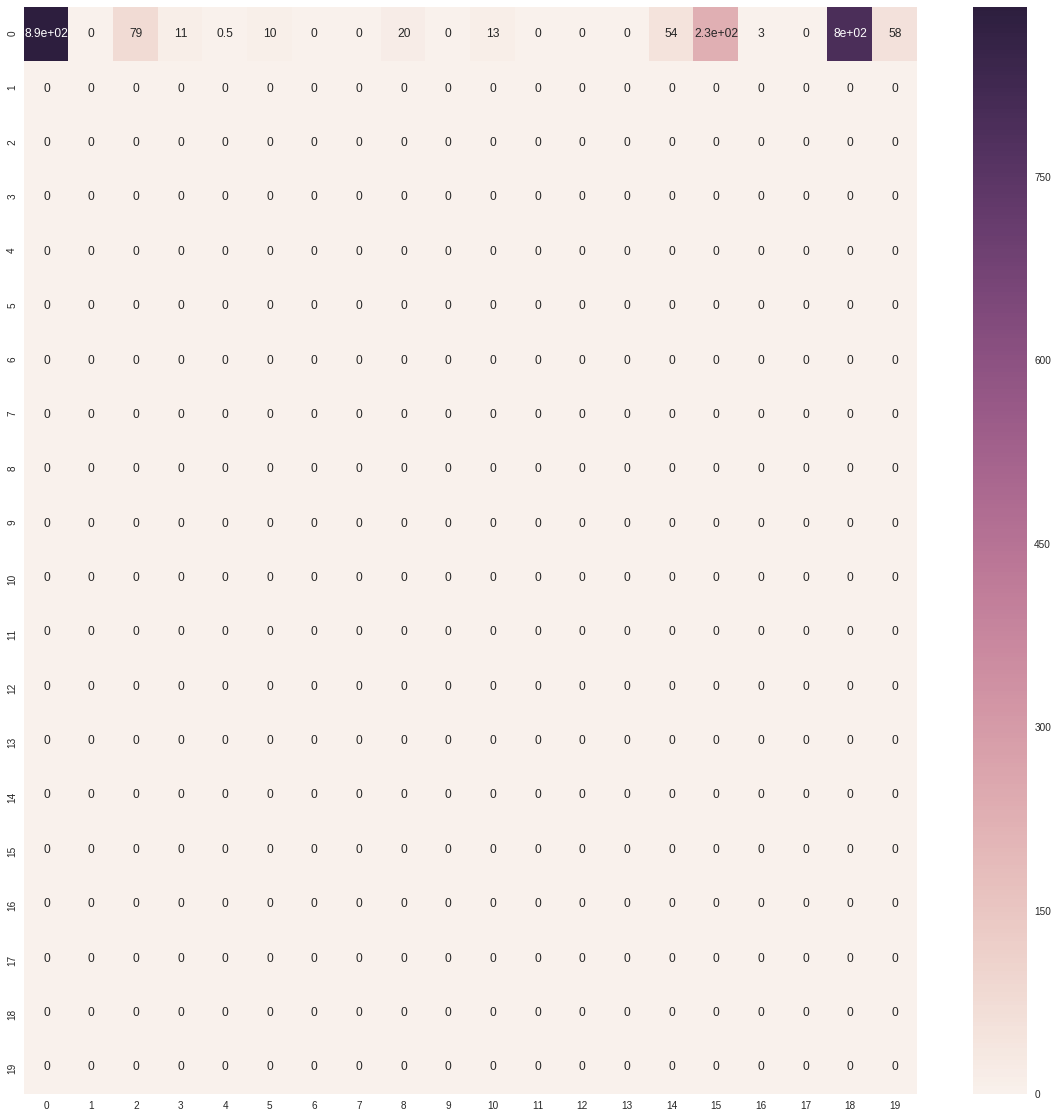

In [263]:
plot_mat_confusion(parameters.name_network,parameters.train_number,2)

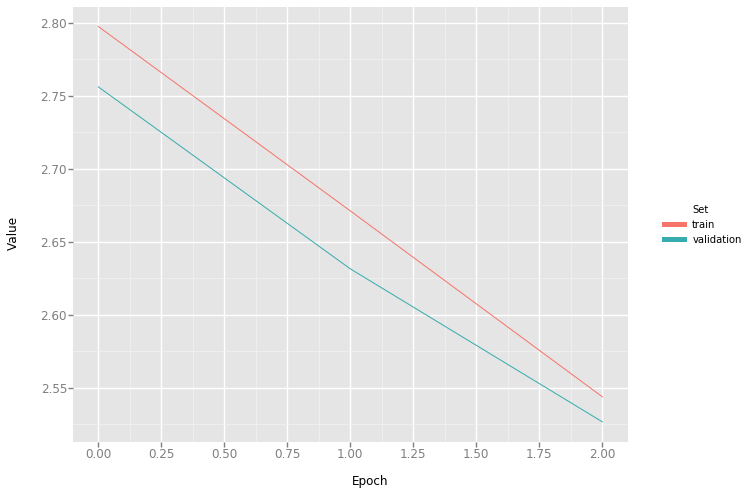

<ggplot: (8766565966975)>


In [122]:
plot_loss(parameters.name_network,parameters.train_number)

In [27]:
network = gridNet(nInputs = parameters.nFeatureMaps_init,nOutputs = 20,
                      nColumns = parameters.nColumns,nFeatMaps = parameters.nFeatMaps, dropFactor = parameters.dropFactor)
optimizer2 = optim.Adam(params = network.parameters(), lr = 0.5,
                           betas = (parameters.beta1, parameters.beta2),
                           eps = parameters.epsilon, weight_decay = parameters.weight_decay)


print(network.nColumns)
#print(optimizer2.state)

a = load_from_checkpoint(path_checkpoint="Model/0test0checkpoint.pth.tar",network=network,optimizer=optimizer2)
#print(optimizer2.lr)
print(a.path_data)

2
=> loading checkpoint 'Model/0test0checkpoint.pth.tar'
=> loaded checkpoint 'Model/0test0checkpoint.pth.tar' (epoch 1)
<bound method Module.named_parameters of gridNet(
  (batchNormInitial): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (firstConv): firstConv(
    (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (ReLU1): ReLU()
    (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (ReLU2): ReLU()
  )
  (convSequence0_0to0_1): convSequence(
    (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU1): ReLU()
    (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU2): ReLU()
  )
  (subSamplingSequen

In [78]:
train2(network = network, parameters = parameters, train_loader = train_loader, val_loader = val_loader)

plot_loss(name_network = parameters.name_network, train_number = parameters.train_number)

plot_confusion(parameters.name_network,parameters.train_number)